In [1]:
import os
import sys

import logging
import re
import pathlib

import datetime

import numpy as np
import pandas as pd
from scipy.stats import pearsonr

import matplotlib.pyplot as plt

from pyplink import PyPlink

import statsmodels.api as sm

from basic_tools import *
import glob

In [2]:
plink_KCHIP_HLA_AA_SNP_1000G=PyPlink(plink_KCHIP_HLA_AA_SNP_1000G_path)
plink_KCHIP_HLA_AA_SNP_1000G_fam=plink_KCHIP_HLA_AA_SNP_1000G.get_fam().astype({'fid':str,'iid':str}).rename(columns={'fid':'FID','iid':'IID'})
plink_KCHIP_HLA_AA_SNP_1000G_bim=plink_KCHIP_HLA_AA_SNP_1000G.get_bim()

In [3]:
phenotypes=pd.read_csv(pheno_all_file_path,sep='\t')
'  '.join(phenotypes.columns)

'ID  age  sex  asthma  chronic_bronchitis  allergic_disease  stomach_cancer  liver_cancer  colorectal_cancer  breast_cancer  cervical_cancer  lung_cancer  thyroid_cancer  prostate_cancer  bladder_cancer  colon_polyps  angina_pectoris_myocardial_infarction  hypertension  stroke  transient_ischemic_attacks  acute_liver_disease  diabetes  t2_diabetes  hyperlipidemia  thyroid_disease  arthritis  rheumatoid_arthritis  osteoporosis  parkinson  pwi_total  chronic_gastritis_stomach_ulcer  duodenal_ulcer  urinary_tract_infection  height  hip_circumference  waist_circumference  weight  systolic_blood_pressure  diastolic_blood_pressure  pulse  hysterectomy  menarche_onset_age  menopause_age  menopause_cycle  ovarian_extraction  child_delivery_number  big_baby  small_baby  child_present  child_dead  hematocrit  hemoglobin  platelet  rbc  wbc  mcv  mch  mchc  total_bilirubin  bun  creatinine  blood_in_urine  glucose_in_urine  alt  ast  gtp  total_cholesterol  hdl_cholesterol  hba1c  freet4  tsh  tr

In [4]:
phenotypes=phenotypes.set_index('ID').loc[plink_KCHIP_HLA_AA_SNP_1000G_fam['IID']]
phenotypes.shape

(125673, 101)

In [5]:
assert (phenotypes.index!=plink_KCHIP_HLA_AA_SNP_1000G_fam['IID']).sum()==0

In [6]:
binary_continuous_traits=phenotypes.columns.difference(['age','sex','cohort','diabetes'])
binary_continuous_traits,len(binary_continuous_traits)

(Index(['FEV_over_FVC_predicted', 'FEV_predicted', 'FVC_predicted',
        'MVV_predicted', 'acute_liver_disease', 'albumin', 'allergic_disease',
        'alt', 'angina_pectoris_myocardial_infarction', 'arthritis', 'ast',
        'asthma', 'benign_prostatic_hyperplasia', 'big_baby', 'bladder_cancer',
        'blood_in_urine', 'bmi', 'bone_density_distal_sos',
        'bone_density_midshaft_sos', 'breast_cancer', 'bun', 'cataract',
        'cervical_cancer', 'child_dead', 'child_delivery_number',
        'child_present', 'cholelithiasis_cholecystitis', 'chronic_bronchitis',
        'chronic_gastritis_stomach_ulcer', 'colon_polyps', 'colorectal_cancer',
        'copd', 'creatinine', 'diastolic_blood_pressure', 'duodenal_ulcer',
        'fatty_liver', 'fracture', 'freet4', 'glaucoma', 'glucose_in_urine',
        'gout', 'grip_strength', 'gtp', 'hba1c', 'hdl_cholesterol',
        'heart_failure', 'height', 'hematocrit', 'hemoglobin',
        'hip_circumference', 'hscrp', 'hyperlipidemia',

In [8]:
phenotype_name='t2_diabetes'

In [9]:
pheno=pd.read_csv(data_out_pheno_path+phenotype_name+'.phe',sep='\t',header=None,names=['FID','IID','pheno'])
phenotype_type='binary' if len(pheno['pheno'][pheno['pheno']!=-9].value_counts())<3 else 'continuous'
phenotype_type

'binary'

In [10]:
pd.read_csv('data/out_gcta/{}.HEreg'.format(phenotype_name),sep=r'\s+')

,,,,,HE-CP
Coefficient,Estimate,SE_OLS,SE_Jackknife,P_OLS,P_Jackknife
Intercept,-1.12233e-05,1.58691e-05,2.04526e-07,0.479417,0
V(G)/Vp,0.000603416,0.000105658,0.000277052,1.1228e-08,0.0294068
HE-SD,NaN,NaN,NaN,NaN,NaN
Coefficient,Estimate,SE_OLS,SE_Jackknife,P_OLS,P_Jackknife
Intercept,-1,3.43968e-05,0.00911003,0,0
V(G)/Vp,0.000473182,0.000229016,0.000530214,0.0388137,0.372161


In [11]:
result_list=[]
for phenotype_name in binary_continuous_traits:
    #pheno[pheno['pheno']!=-9].to_csv(data_out_gcta_path+phenotype_name+'.phe',sep='\t',index=None,header=None)
    try:
        result=pd.read_csv('data/out_gcta/{}.HEreg'.format(phenotype_name),skiprows=[0,5,6,7,8],sep=r'\s+',index_col=0)
        result=result.astype(float)
        result=result.unstack().to_frame().sort_index(level=1).T
    except:
        print(phenotype_name,'pass')
        continue

    result.columns = result.columns.map(lambda x: '-'.join(x[::-1]))
    result.index=[phenotype_name]#[result_file.split('/')[-1].split('.')[0]]

    pheno=pd.read_csv(data_out_pheno_path+phenotype_name+'.phe',sep='\t',header=None,names=['FID','IID','pheno'])
    phenotype_type='binary' if len(pheno['pheno'][pheno['pheno']!=-9].value_counts())<3 else 'continuous'
        
    result['phenotype_type']=phenotype_type
    #print(result.columns)
    if phenotype_type=='binary':
        with open(data_out_pheno_path+phenotype_name+'.phe'+'.prev','r') as f:
            prev=float(f.read())
        #print('prev',prev)   
        result['prevalence']=prev
    result_list.append(result)  

freet4 pass
peripheral_vascular_diseases pass


In [12]:
result_concat=pd.concat(result_list)

/home/ch6845/tools/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [13]:
from scipy.stats import norm
def h2_obs_to_liab(h2_obs, P, K):
    '''
    Converts heritability on the observed scale in an ascertained sample to heritability
    on the liability scale in the population.
    Parameters
    ----------
    h2_obs : float
        Heritability on the observed scale in an ascertained sample.
    P : float in (0,1)
        Prevalence of the phenotype in the sample.
    K : float in (0,1)
        Prevalence of the phenotype in the population.
    Returns
    -------
    h2_liab : float
        Heritability of liability in the population.
    '''
    if np.isnan(P) and np.isnan(K):
        return h2_obs
    if K <= 0 or K >= 1:
        raise ValueError('K must be in the range (0,1)')
    if P <= 0 or P >= 1:
        raise ValueError('P must be in the range (0,1)')

    thresh = norm.isf(K)
    conversion_factor = K ** 2 * \
        (1 - K) ** 2 / (P * (1 - P) * norm.pdf(thresh) ** 2)
    return h2_obs * conversion_factor

In [14]:
binary_continuous_traits.sort_values()

Index(['FEV_over_FVC_predicted', 'FEV_predicted', 'FVC_predicted',
       'MVV_predicted', 'acute_liver_disease', 'albumin', 'allergic_disease',
       'alt', 'angina_pectoris_myocardial_infarction', 'arthritis', 'ast',
       'asthma', 'benign_prostatic_hyperplasia', 'big_baby', 'bladder_cancer',
       'blood_in_urine', 'bmi', 'bone_density_distal_sos',
       'bone_density_midshaft_sos', 'breast_cancer', 'bun', 'cataract',
       'cervical_cancer', 'child_dead', 'child_delivery_number',
       'child_present', 'cholelithiasis_cholecystitis', 'chronic_bronchitis',
       'chronic_gastritis_stomach_ulcer', 'colon_polyps', 'colorectal_cancer',
       'copd', 'creatinine', 'diastolic_blood_pressure', 'duodenal_ulcer',
       'fatty_liver', 'fracture', 'freet4', 'glaucoma', 'glucose_in_urine',
       'gout', 'grip_strength', 'gtp', 'hba1c', 'hdl_cholesterol',
       'heart_failure', 'height', 'hematocrit', 'hemoglobin',
       'hip_circumference', 'hscrp', 'hyperlipidemia', 'hypertension

In [60]:
result_concat.loc[ 'rheumatoid_arthritis']

Intercept-Estimate        -0.00020126
Intercept-P_Jackknife      1.8076e-28
Intercept-P_OLS              0.479158
Intercept-SE_Jackknife    1.81851e-05
Intercept-SE_OLS          0.000284403
V(G)/Vp-Estimate         -0.000358185
V(G)/Vp-P_Jackknife          0.870999
V(G)/Vp-P_OLS                0.847176
V(G)/Vp-SE_Jackknife       0.00220571
V(G)/Vp-SE_OLS             0.00185855
phenotype_type                 binary
prevalence                  0.0500854
h2_liab                   -0.00159773
Name: rheumatoid_arthritis, dtype: object

In [15]:
result_concat['h2_liab']=result_concat.apply(lambda row: h2_obs_to_liab(row['V(G)/Vp-Estimate'],row['prevalence'],row['prevalence']) if row['phenotype_type']=='binary' else row['V(G)/Vp-Estimate'],axis=1)

In [16]:
result_concat.to_csv(data_out_gcta_path+'result_uni.tsv',sep='\t')

/home/ch6845/tools/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.


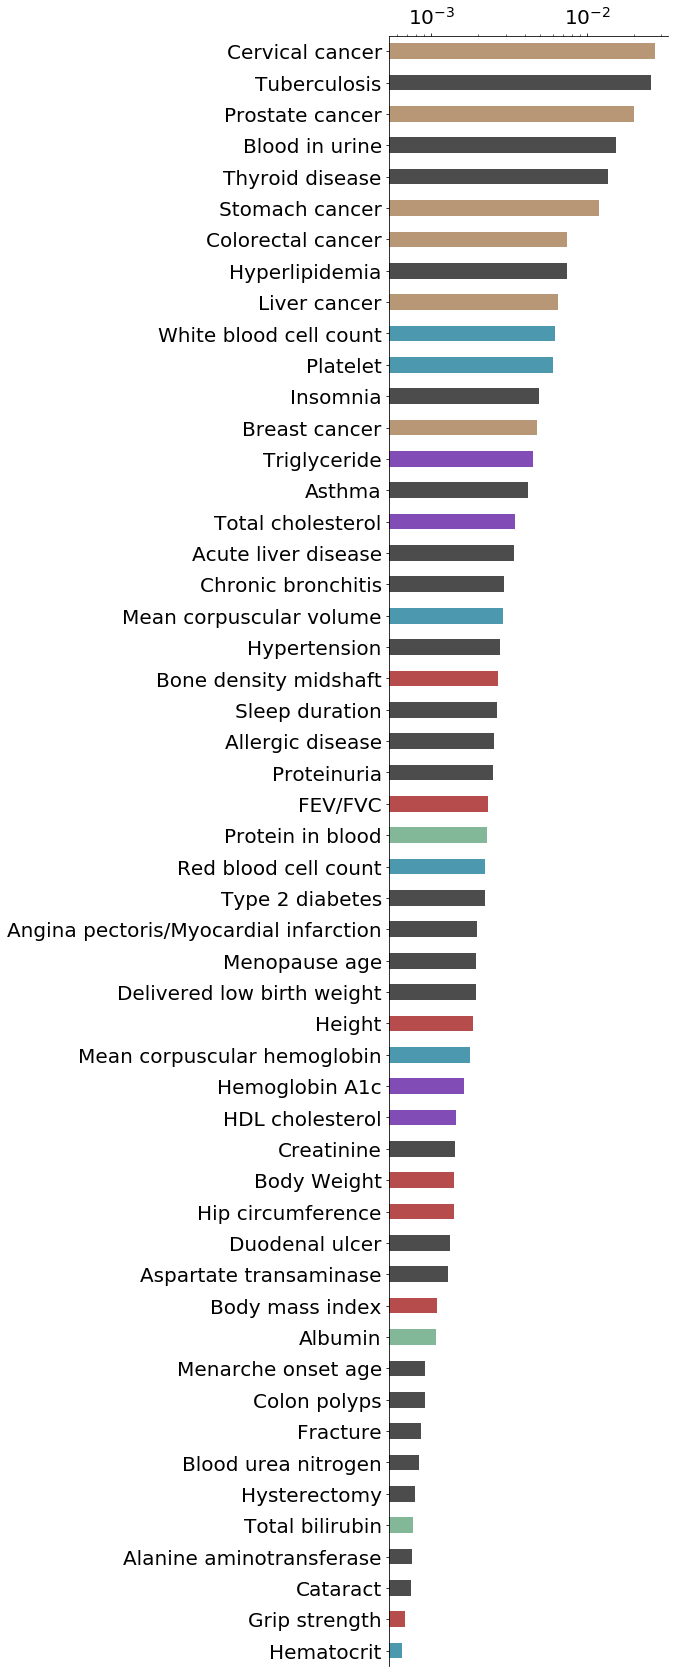

In [18]:
toplot=result_concat[result_concat['h2_liab']>0]
toplot=toplot.sort_values('h2_liab',ascending=True).iloc[int(3*len(toplot)/10):]

phenotype_info=pd.read_csv('data/phenotype_pubname.tsv',sep='\t',index_col=0)

phenotype_info.loc[toplot.index]

plt.rcParams["figure.figsize"] = (5,30)
plt.rcParams["font.size"] = 20


phenotype_category_color=pd.Series(index=phenotype_info.loc[toplot.index]['phenotype_category'].unique())
cnt=1
for phenotype_category,row in phenotype_category_color.items():
    if 'Other' in phenotype_category:
        phenotype_category_color[phenotype_category]=0
        
    elif (phenotype_info.loc[toplot.index]['phenotype_category']==phenotype_category).sum()<3:
        phenotype_category_color[phenotype_category]=0
    else:
        phenotype_category_color[phenotype_category]=cnt;cnt+=1
#print(phenotype_category_color)
cmap_temp=plt.cm.rainbow(np.linspace(0,1,phenotype_category_color.max()))
cmap_temp=[[color[0]*0.6,color[1]*0.6,color[2]*0.6,color[3]] for color in cmap_temp]
np.random.shuffle(cmap_temp)
cmap_temp=np.concatenate(([[0,0,0,1]],cmap_temp))   
#print(phenotype_category_color)
phenotype_category_color=phenotype_category_color.map(lambda x: cmap_temp[int(x)])

colors=phenotype_category_color.loc[phenotype_info.loc[toplot.index]['phenotype_category']].values

toplot.index=phenotype_info.loc[toplot.index]['phenotype_name_publication']

ax=toplot['h2_liab'].plot.barh(linewidth=0.1,color=colors,alpha=0.7)

plt.ylabel('')
plt.xlabel('')

ax.xaxis.set_ticks_position('top')
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)

plt.xscale('log')

plt.savefig('figure_h2.svg', bbox_inches='tight')

In [20]:
phenotype_category_color

Hematological QTL           [0.00117647058823529, 0.42556878456351205, 0.5...
Anthropometric QTL          [0.6, 7.347880794884119e-17, 3.673940397442059...
Eye-related disease                                      [0.0, 0.0, 0.0, 1.0]
Liver-related QTL                                        [0.0, 0.0, 0.0, 1.0]
Protein QTL                 [0.30235294117647055, 0.5999886164092361, 0.42...
Other diseases                                           [0.0, 0.0, 0.0, 1.0]
Kidney-related QTL                                       [0.0, 0.0, 0.0, 1.0]
Orthopedic disorders                                     [0.0, 0.0, 0.0, 1.0]
Other QTL                                                [0.0, 0.0, 0.0, 1.0]
Metabolic QTL                                            [0.3, 0.0, 0.6, 1.0]
Cardiovascular disease                                   [0.0, 0.0, 0.0, 1.0]
Metabolic diseases                                       [0.0, 0.0, 0.0, 1.0]
Immune-related diseases                                  [0.0, 0

In [93]:
toplot['h2_liab'].sort_values(ascending=True).plot.barh?

Object `plot.barh` not found.


In [ ]:
toplot['h2_liab'].sort_values(ascending=True).plot.barh

In [94]:
toplot['h2_liab'].sort_values(ascending=True).plot.barh

<bound method SeriesPlotMethods.barh of <pandas.plotting._core.SeriesPlotMethods object at 0x7f12205ea2b0>>

In [101]:
toplot

,Intercept-Estimate,Intercept-P_Jackknife,Intercept-P_OLS,Intercept-SE_Jackknife,Intercept-SE_OLS,V(G)/Vp-Estimate,V(G)/Vp-P_Jackknife,V(G)/Vp-P_OLS,V(G)/Vp-SE_Jackknife,V(G)/Vp-SE_OLS,phenotype_type,prevalence,h2_liab
pwi_total,-0.000009,0.000000e+00,0.479508,8.483010e-08,0.000013,0.000031,8.087900e-01,7.308720e-01,0.000127,0.000089,continuous,NaN,0.000031
osteoporosis,-0.000012,0.000000e+00,0.479467,2.740450e-07,0.000017,0.000009,9.427920e-01,9.367220e-01,0.000125,0.000113,binary,0.047926,0.000041
FVC_predicted,-0.000134,0.000000e+00,0.479416,3.062940e-06,0.000190,0.000071,9.654350e-01,9.549290e-01,0.001637,0.001255,continuous,NaN,0.000071
child_delivery_number,-0.000014,0.000000e+00,0.479514,1.780710e-07,0.000020,0.000086,6.675280e-01,5.155620e-01,0.000201,0.000133,continuous,NaN,0.000086
big_baby,-0.000013,0.000000e+00,0.479460,3.256120e-07,0.000018,0.000020,9.039920e-01,8.672760e-01,0.000168,0.000121,binary,0.042832,0.000100
copd,-0.000015,3.469510e-12,0.478359,2.092450e-06,0.000021,0.000002,9.901320e-01,9.882640e-01,0.000162,0.000137,binary,0.001798,0.000109
stroke,-0.000012,4.712260e-107,0.479379,5.571110e-07,0.000017,0.000012,9.342300e-01,9.146550e-01,0.000150,0.000115,binary,0.014363,0.000131
thyroid_cancer,-0.000012,7.130330e-40,0.479179,9.374970e-07,0.000018,0.000006,9.694760e-01,9.573410e-01,0.000163,0.000117,binary,0.005419,0.000139
pulse,-0.000008,0.000000e+00,0.479566,7.038740e-08,0.000012,0.000153,2.130010e-01,4.915270e-02,0.000123,0.000078,continuous,NaN,0.000153
glaucoma,-0.000013,6.111190e-37,0.479156,1.033030e-06,0.000019,0.000008,9.647810e-01,9.474600e-01,0.000185,0.000124,binary,0.005328,0.000184


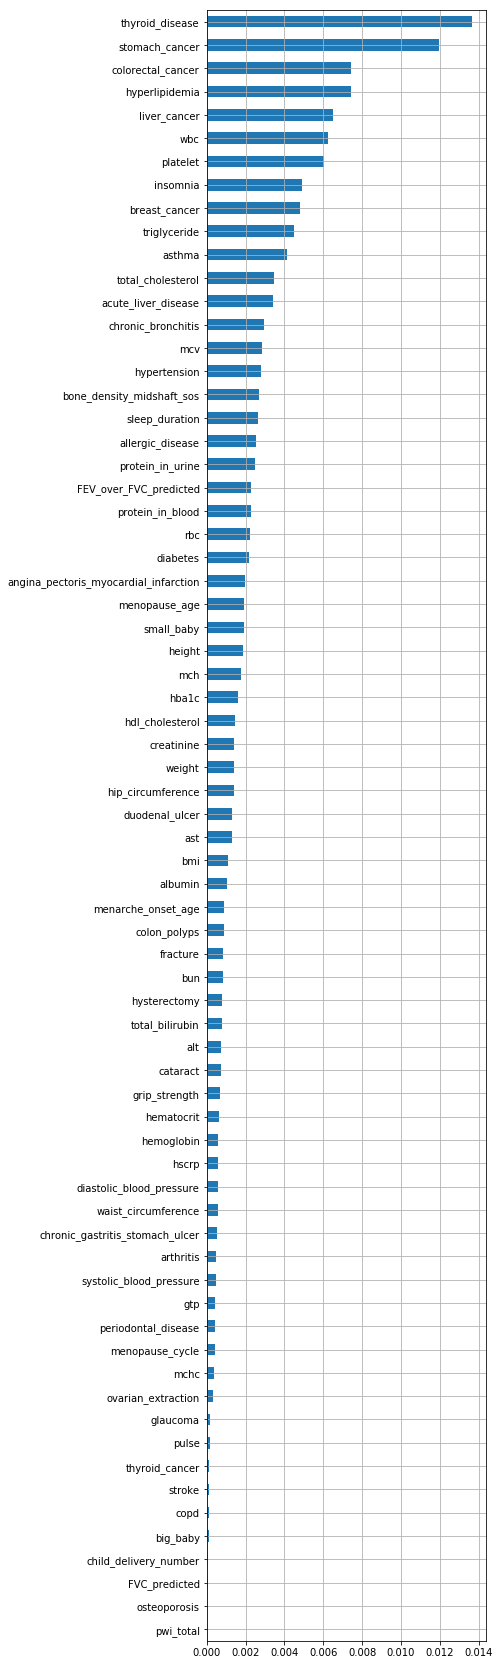

In [100]:
toplot['h2_liab'].sort_values(ascending=True).plot.barh(grid=True)#,color=phenotype_category_color.loc[phenotype_info.loc[toplot.index]['phenotype_category']].values)

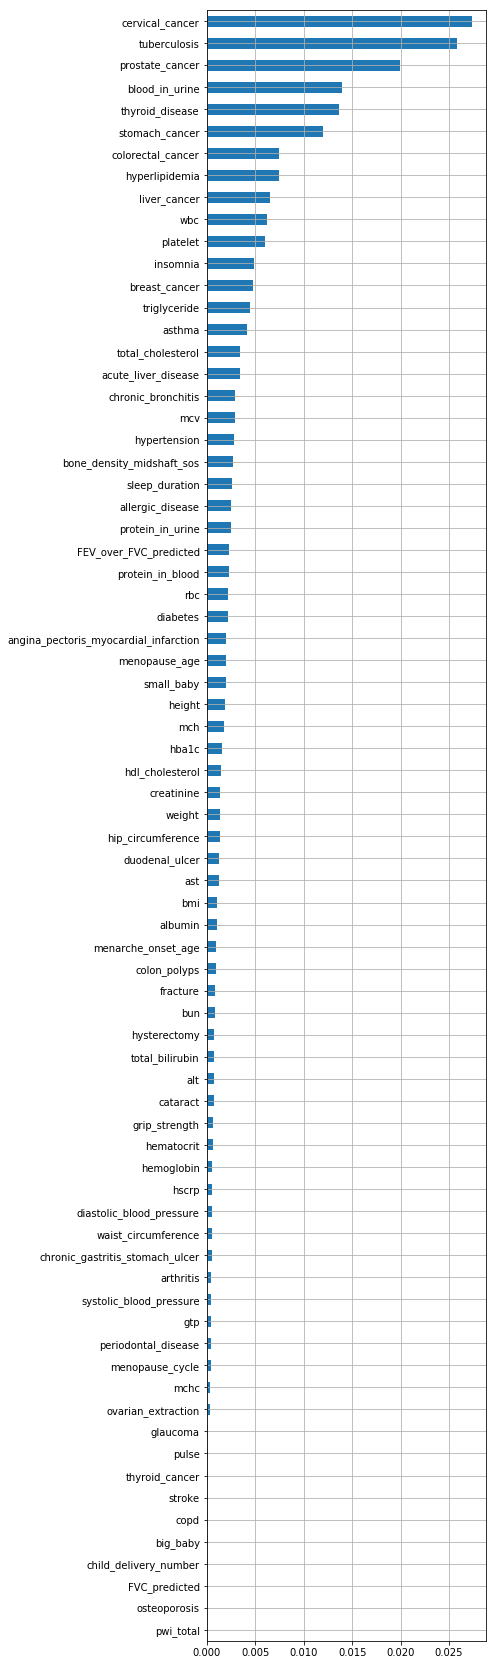

In [57]:
plt.rcParams["figure.figsize"] = (5,30)
plt.rcParams["font.size"] = 10

result_concat[result_concat['h2_liab']>0]['h2_liab'].sort_values(ascending=True).plot.barh(grid=True)

plt.savefig('temp.png')

In [97]:
import re

In [36]:
with open(result_file,'r') as f:
    a=f.read()
    #print(f.read().strip().strip(r'\s*').split('\n')[1:5])

In [35]:
pd.read_csv(result_file,sep=r'\s+',index_col=0)

NameError: name 'result_file' is not defined

In [54]:
#result_select=result[['Estimate_V(G)/Vp_HE-SD','P_OLS_V(G)/Vp_HE-SD']]
#result_select.columns=['estimate','p']

In [173]:
result_select=result_select[(result_select['estimate']>0)&(result_select['p']<0.01)].sort_values('p')

In [169]:
result_select.to_csv(data_out_gcta_path+'result_uni.tsv',sep='\t')

In [179]:
result.to_csv("result.tsv",sep='\t')

In [62]:
result_concat.columns

Index(['Intercept-Estimate', 'Intercept-P_Jackknife', 'Intercept-P_OLS',
       'Intercept-SE_Jackknife', 'Intercept-SE_OLS', 'V(G)/Vp-Estimate',
       'V(G)/Vp-P_Jackknife', 'V(G)/Vp-P_OLS', 'V(G)/Vp-SE_Jackknife',
       'V(G)/Vp-SE_OLS'],
      dtype='object')

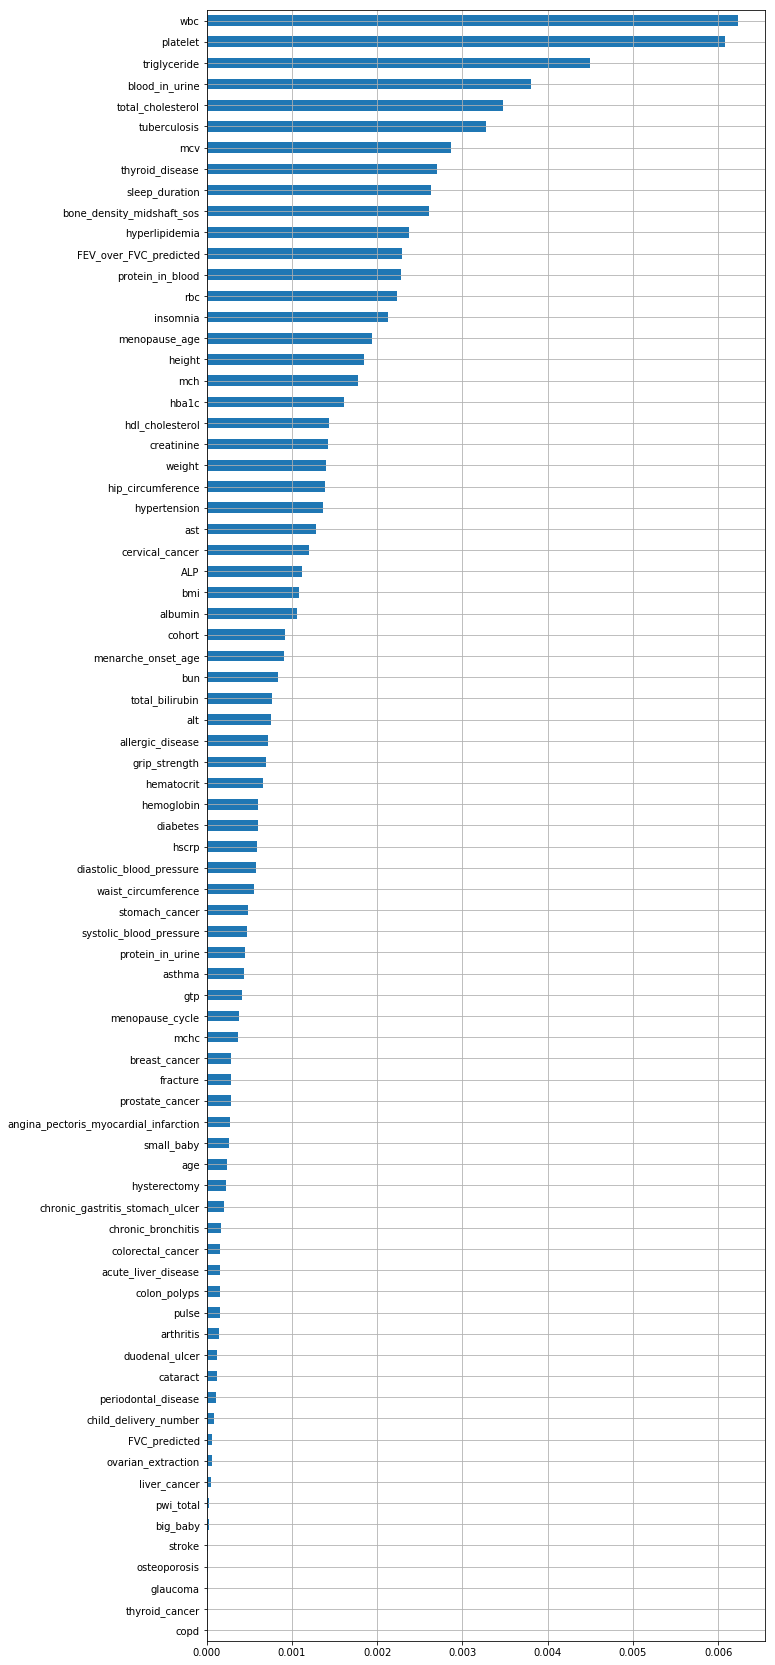

In [15]:
plt.rcParams["figure.figsize"] = (10,30)
plt.rcParams["font.size"] = 10

result_concat[result_concat['V(G)/Vp-Estimate']>0]['V(G)/Vp-Estimate'].sort_values(ascending=True).plot.barh(grid=True)

plt.savefig('temp.png')

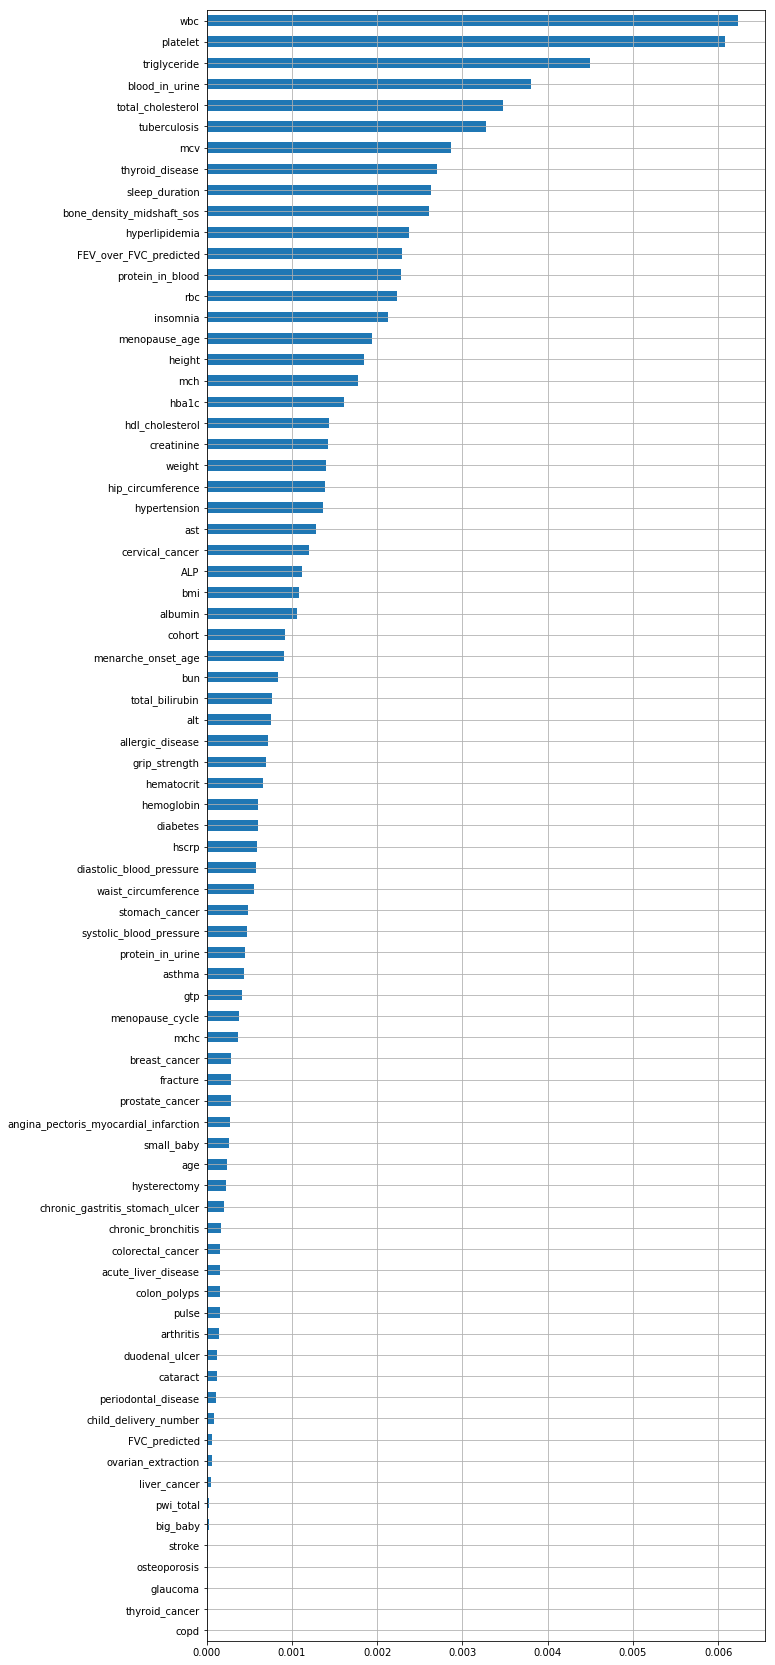

In [88]:
plt.rcParams["figure.figsize"] = (10,30)
plt.rcParams["font.size"] = 10

result_concat[result_concat['V(G)/Vp-Estimate']>0]['V(G)/Vp-Estimate'].sort_values(ascending=True).plot.barh(grid=True)